In this notebook, we will apply the information-matching method to find the optimal PMU placements that leads to full system observability.
The objective is translated to requiring non-singular FIM of the system.
In practice, we set the target FIM to be a diagonal matrix, where the diagonal element is set to be some small positive number.
By doing this, the eigenvalues of the optimal FIM are larger than this small number, and thus the FIM is non-singular.

Details of the calculation:
* Model: IEEE 39-bus system
* Candidate data: Voltage phasor at each bus
* Eigenvalue cutoff: 1e-5

In [1]:
from pathlib import Path
import random

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from information_matching.convex_optimization import ConvexOpt
from information_matching.utils import tol, eps

random.seed(1)
%matplotlib inline
plt.style.use("default")

In [2]:
# Set directories
case = 39  # 39-bus case

WORK_DIR = Path().absolute()
FIM_DIR = WORK_DIR / "FIMs"
DATA_DIR = WORK_DIR / "models" / "data"

# Setup

In [3]:
# Model information
nparams = 2 * case

## Get FIMs for candidate configurations

With some arguments, we might want to exclude some buses and preassigned PMUs on some buses.

For example, we can consider the formulation in https://ieeexplore.ieee.org/document/4519389, where the authors have some preassigned buses to place PMUs and exclude some buses as candidates.

In [4]:
# No preassigned buses and include all buses as candidate locations
preassigned_buses = np.array([], dtype=int)
candidate_buses = np.arange(case) + 1

# # Some preassigned buses and few candidates from the paper
# # https://ieeexplore.ieee.org/document/4519389
# preassigned_buses = np.array([20, 23, 25, 29], dtype=int)
# candidate_buses = np.array(
#     [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15,
#      16, 17, 18, 19, 21, 22, 24, 26, 27, 28, 39,]
#     dtype=int,
# )

In [5]:
# Finalize the candidate buses after considering preassigned buses
candidate_buses=np.sort(np.unique(np.append(preassigned_buses,candidate_buses)))

# Configurations
nconfigs = len(candidate_buses)
configs = candidate_buses
config_ids = np.array([f"bus{ii}" for ii in configs])
config_ids

array(['bus1', 'bus2', 'bus3', 'bus4', 'bus5', 'bus6', 'bus7', 'bus8',
       'bus9', 'bus10', 'bus11', 'bus12', 'bus13', 'bus14', 'bus15',
       'bus16', 'bus17', 'bus18', 'bus19', 'bus20', 'bus21', 'bus22',
       'bus23', 'bus24', 'bus25', 'bus26', 'bus27', 'bus28', 'bus29',
       'bus30', 'bus31', 'bus32', 'bus33', 'bus34', 'bus35', 'bus36',
       'bus37', 'bus38', 'bus39'], dtype='<U5')

In [6]:
# Load configuration FIMs
fim_configs_tensor = np.empty((nconfigs, nparams, nparams))
for ii, bus in enumerate(configs):
    ff = np.loadtxt(FIM_DIR / f"fim_bus{bus}.csv", delimiter=",")
    fim_configs_tensor[ii] = ff
# Scaling factor to help the convex optimization
norm = max(np.linalg.norm(fim_configs_tensor, axis=(1, 2)))
fim_configs_tensor[0].shape

(78, 78)

## Get the target FIM

Like in the IEEE 14-bus system case, we will also set the target FIM to be a diagonal matrix with a positive cutoff value for the eigenvalues on the diagonal.
However, one thing that is different is that we might have preassigned buses in this case.
To incorporate this information, we will subtract the FIMs from the preassigned buses (with weight 1.0) from the target FIM.
That is, the effective target FIM is the diagonal matrix minus the FIMs from the preassigned buses.

In [7]:
# Load the FIM of the preassigned buses and sum them up
fim_preassigned = np.zeros((nparams, nparams))
for bus in preassigned_buses:
    ff = np.loadtxt(DATA_DIR / "FIMs" / f"fim_bus{bus}.csv", delimiter=",")
    fim_preassigned += ff

In [8]:
# Matrix to impose tolerance for the non-zero eigenvalues
lambda_tol = 1e-5
fim_tol = lambda_tol * np.eye(nparams)
print("Eigenvalue lower bound:", lambda_tol)

Eigenvalue lower bound: 1e-05


In [9]:
# Effective target FIM
# Constant matrix on the RHS of the PSD constraint
fim_target = fim_tol - fim_preassigned

# Convex optimization

Additional note:

We will perform the optimization iteratively.
In each iteration, we scale the weights being optimize by the optimal weights from the previous iteration.
By doing so, the objective function in the convex optimization better mimics $\ell_0$-norm to enforce sparsity.

In [10]:
# Construct the input FIMs
# FIM target is fine, because we only apply scale 1.0
# FIM configs
fim_configs = {}
for ii, identifier in enumerate(config_ids):
    fim_configs.update(
        {identifier: {"fim": fim_configs_tensor[ii], "fim_scale": 1 / norm}}
    )

In [11]:
# Before running the optimization, we have performed similar calculation, but with
# Mixed-integer semi-definite programming (MISDP) problem in Matlab. That result can
# be used as an initial guess to speed up the calculation here. As suppose to the
# MISDP version of the method, the regular SDP version can find continuous values.
opt_buses_misdp = np.loadtxt(
    WORK_DIR / "data" / "misdp_optimal_buses.txt", delimiter=",", dtype=int
)
opt_buses_misdp_idx = opt_buses_misdp - 1

Tolerance: 1.8189894035458565e-12
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.825754669014069e-08


/home/byu.local/yonatank/.local/lib/python3.7/site-packages/cvxpy/problems/problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.546394305590102e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.394708392357836e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 6.234448689676636e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.250649003198947e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.5883744234016e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.013997620764836e-08
Step length is too small.  :: line 198 in 

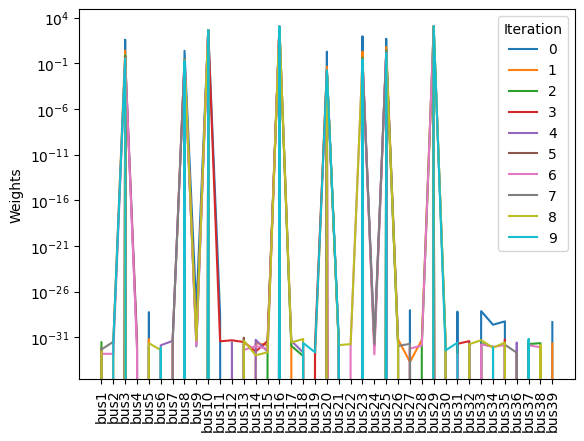

In [12]:
# Convex optimization
# Settings
cvx_tol = eps ** 0.75
solver = dict(verbose=False, warm_start=True, solver=cp.SDPA, epsilonStar=cvx_tol)
print("Tolerance:", cvx_tol)

plt.figure()
# Use the MISDP result as an initial guess
wopt = np.zeros(nconfigs)
wopt[opt_buses_misdp_idx] = 1.0
for ii in range(10):
    # Update the weight scales
    for jj, identifier in enumerate(config_ids):
        # Add weight scale information,aAdd some small number for numerical stability
        fim_configs[identifier].update({"weight_scale": 1 / (wopt[jj] + 1e-15)})
    cvxopt = ConvexOpt(fim_target, fim_configs, l1norm_obj=True)

    try:
        # Solve
        if ii == 0:
            cvxopt.wm.value = wopt.reshape((-1, 1))
        cvxopt.solve(**solver)
        result = cvxopt.result.copy()
        wopt = result["wm"]
        dual = result["dual_wm"]
        print("Violation:", cvxopt.constraints[1].violation())
    except Exception:
        cvxopt.result = result
        break

    plt.plot(wopt, label=ii)

print("Optimal value:", result["value"])

plt.yscale("log")
plt.xticks(range(nconfigs), config_ids, rotation=90)
plt.ylabel("Weights")
plt.legend(title="Iteration", bbox_to_anchor=(1, 1))
plt.show()

## Post-processing

In [13]:
# # Plot the weights of the last step
# plt.figure()
# plt.title(f"Eigenvalue lower bound: {lambda_tol:0.3e}")
# plt.plot(wopt, label="weights")
# plt.plot(dual, label="dual weights")
# plt.yscale("log")
# plt.xticks(range(nconfigs), config_ids, rotation=90)
# plt.legend()
# plt.show()

In [14]:
# Get the optimal buses
idx_wopt = np.where(wopt > cvx_tol)[0]  # Index to the optimal buses
print("Optimal buses:")
_ = [print(f'{config_ids[ii]} \t {wopt[ii]}') for ii in idx_wopt]

Optimal buses:
bus3 	 0.3492993094346862
bus8 	 0.20153402283680275
bus10 	 451.75052046258276
bus16 	 1139.7245814229434
bus20 	 0.01705235535891223
bus23 	 0.26533335719490586
bus25 	 1.4609945279636305
bus29 	 1254.6382482827164


Eigenvalues:
[2.09950191e+01 2.10711372e+01 2.20544809e+01 2.22259942e+01
 2.32848480e+01 2.39069230e+01 2.46185358e+01 2.64253172e+01
 3.95334465e+01 4.09824723e+01 5.25155260e+01 5.34115281e+01
 8.24071700e+01 8.26475841e+01 1.04730800e+02 1.05522791e+02
 2.28143122e+02 2.41129754e+02 3.19351863e+02 3.57521810e+02
 5.21306945e+02 5.45913481e+02 6.74476652e+02 7.09525836e+02
 1.61571155e+03 1.73056118e+03 1.75935360e+03 1.85784855e+03
 3.67058270e+03 3.92304137e+03 1.06235786e+04 1.16555852e+04
 1.70289808e+04 1.73136399e+04 1.85212254e+05 1.88490178e+05
 4.09468789e+05 4.52010311e+05 8.50118935e+05 8.66034763e+05
 9.02679110e+05 9.19645253e+05 3.50162104e+06 3.74062627e+06
 5.14920128e+06 5.53993251e+06 7.42198523e+06 7.87307779e+06
 1.21381147e+07 1.31218418e+07 1.54690106e+07 1.67020636e+07
 1.69645804e+07 1.76343741e+07 2.15893536e+07 2.28027340e+07
 2.30573380e+07 2.40280718e+07 6.82435197e+07 7.33390553e+07
 1.06746604e+08 1.10316124e+08 1.29349096e+08 1.39455693e+08
 1.87435481

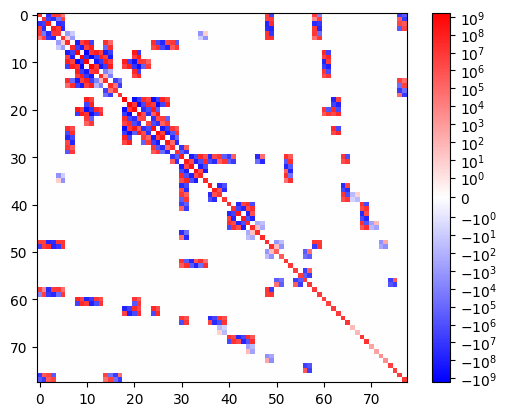

In [15]:
# Test the optimal buses
weighted_fims_configs = fim_configs_tensor * wopt.reshape((-1, 1, 1))
I = np.sum(weighted_fims_configs[idx_wopt], axis=0)
print("Eigenvalues:")
print(np.linalg.eigvalsh(I))

plt.figure()
cbound = np.max([abs(np.min(I)), abs(np.max(I))])
plt.imshow(I, cmap="bwr", norm=mpl.colors.SymLogNorm(1e0, vmin=-cbound, vmax=cbound))
plt.colorbar()
plt.show()

Even though the smallest eigenvalue of the optimal FIM is smaller than the cutoff, but they are pretty close.
We believe this is just numerical artifact.